# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path
from itertools import product
import random

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename, load_parquet_subset
from lib.aggregate.cell_data_utils import split_cell_data, channel_combo_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    query_filter,
    perturbation_filter,
    missing_values_filter,
    intensity_filter,
)
from lib.aggregate.align import (
    prepare_alignment_data,
    pca_variance_plot,
    embed_by_pca,
    tvn_on_controls,
)
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import (
    nas_summary,
    summarize_cell_data,
    plot_feature_distributions,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

random.seed(42)

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL_1`: First well identifier used for testing configuration
- `TEST_WELL_2`: Second well identifier used for testing configuration

In [3]:
TEST_PLATE = 5
TEST_WELL_1 = "A1"
TEST_WELL_2 = "A2"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_1}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=25000)

merge_final_fp_2 = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_2}, "merge_final", "parquet")
)
cell_data_2 = load_parquet_subset(merge_final_fp_2, n_rows=25000)

cell_data = pd.concat([cell_data, cell_data_2], ignore_index=True)
cell_data

Reading first 25,000 rows from analysis_root/merge/parquets/P-5_W-A1__merge_final.parquet
Reading first 25,000 rows from analysis_root/merge/parquets/P-5_W-A2__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,5,A1,765,476,1480.617960,1480.398021,207,221,110.716049,739.370370,...,5,1.000000,51.892764,53.447116,132.981918,5,0.620614,50.231461,56.375007,141.697904
1,5,A1,138,645,1480.787830,1480.082391,27,3139,749.488189,746.598425,...,2,0.538251,67.119173,70.637434,86.247420,2,0.356884,70.473984,70.959338,83.392143
2,5,A1,199,587,1479.814737,1481.478947,57,2807,744.725806,111.741935,...,5,1.000000,51.256842,59.843597,125.378826,5,0.645631,55.045870,56.909717,126.515435
3,5,A1,620,585,1480.131527,1481.907469,156,2435,735.074468,737.914894,...,2,0.395506,64.573843,98.402750,144.595642,2,0.278922,66.897243,98.951225,142.148766
4,5,A1,1049,624,1480.156392,1477.852675,288,351,118.401408,734.049296,...,5,0.891599,71.568709,72.251732,144.939353,5,0.556684,69.558916,70.958721,140.297668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5,A2,585,609,1323.590305,1601.719312,138,5027,1346.976471,760.976471,...,5,1.000000,59.631210,65.420293,115.802175,5,0.615741,61.224834,66.608594,112.643585
49996,5,A2,741,717,1368.303094,1316.277778,178,3182,731.614583,1324.864583,...,4,0.797468,57.294078,62.372804,171.178748,4,0.506024,58.688615,63.036778,166.754164
49997,5,A2,911,668,1577.278732,1652.684280,251,430,141.544554,777.970297,...,7,0.835544,63.316978,64.256427,175.272227,7,0.568592,58.901384,69.645655,172.320277
49998,5,A2,100,764,1586.560487,1312.882507,36,431,136.623529,704.741176,...,6,0.858657,49.421865,57.513778,127.947646,6,0.551020,50.809566,51.776000,136.927676


In [5]:
for col in cell_data.columns:
    print(col)

plate
well
tile
cell_0
i_0
j_0
site
cell_1
i_1
j_1
distance
fov_distance_0
fov_distance_1
sgRNA_0
gene_symbol_0
mapped_single_gene
channels_min
nucleus_DAPI_int
nucleus_TUBULIN_int
nucleus_GH2AX_int
nucleus_PHALLOIDIN_int
nucleus_DAPI_mean
nucleus_TUBULIN_mean
nucleus_GH2AX_mean
nucleus_PHALLOIDIN_mean
nucleus_DAPI_std
nucleus_TUBULIN_std
nucleus_GH2AX_std
nucleus_PHALLOIDIN_std
nucleus_DAPI_max
nucleus_TUBULIN_max
nucleus_GH2AX_max
nucleus_PHALLOIDIN_max
nucleus_DAPI_min
nucleus_TUBULIN_min
nucleus_GH2AX_min
nucleus_PHALLOIDIN_min
nucleus_DAPI_int_edge
nucleus_TUBULIN_int_edge
nucleus_GH2AX_int_edge
nucleus_PHALLOIDIN_int_edge
nucleus_DAPI_mean_edge
nucleus_TUBULIN_mean_edge
nucleus_GH2AX_mean_edge
nucleus_PHALLOIDIN_mean_edge
nucleus_DAPI_std_edge
nucleus_TUBULIN_std_edge
nucleus_GH2AX_std_edge
nucleus_PHALLOIDIN_std_edge
nucleus_DAPI_max_edge
nucleus_TUBULIN_max_edge
nucleus_GH2AX_max_edge
nucleus_PHALLOIDIN_max_edge
nucleus_DAPI_min_edge
nucleus_TUBULIN_min_edge
nucleus_GH2AX_min_e

## <font color='red'>SET PARAMETERS</font>

### Cell Data Metadata

- `METADATA_COLS_FP`: Path to TSV to store metadata cols.
- `METADATA_COLS`: Columns in cell data with metadata (use output above).

In [6]:
METADATA_COLS_FP = "config/cell_data_metadata_cols.tsv"
METADATA_COLS = [
    "plate",
    "well",
    "tile",
    "cell_0",
    "i_0",
    "j_0",
    "site",
    "cell_1",
    "i_1",
    "j_1",
    "distance",
    "fov_distance_0",
    "fov_distance_1",
    "sgRNA_0",
    "gene_symbol_0",
    "mapped_single_gene",
    "channels_min",
    "nucleus_i",
    "nucleus_j",
    "nucleus_bounds_0",
    "nucleus_bounds_1",
    "nucleus_bounds_2",
    "nucleus_bounds_3",
    "cell_i",
    "cell_j",
    "cell_bounds_0",
    "cell_bounds_1",
    "cell_bounds_2",
    "cell_bounds_3",
    "cytoplasm_i",
    "cytoplasm_j",
    "cytoplasm_bounds_0",
    "cytoplasm_bounds_1",
    "cytoplasm_bounds_2",
    "cytoplasm_bounds_3",
]

In [7]:
pd.Series(METADATA_COLS).to_csv(METADATA_COLS_FP, index=False, header=False, sep="\t")

metadata, features = split_cell_data(cell_data, METADATA_COLS)
print(metadata.shape, features.shape)

(50000, 35) (50000, 1649)


## <font color='red'>SET PARAMETERS</font>

### Split cells into classes

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes

### Evaluate splitting

- `COLLAPSE_COLS`: Cell data columns to collapse on when creating a summary of cell counts. This will show the number of cells in each cell class for these particular columns. Ex: `["sgRNA_0", "gene_symbol_0"]`.
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`.

**Notes**: 
- We generate cell classes for each of the classes listed in the classifier and an "all" class. So for a classifier that splits by mitotic or interphase the final classes will be `["mitotic", "interphase", "all"]`.
- You must import necessary packages for the classifier in this notebook and add them to `scripts/aggregate/split_datasets.py` as well. Ex `import numpy as np` if the classifier requires `numpy`.

In [8]:
CLASSIFIER_PATH = "config/binary_xgb_none_model.dill"
MONTAGE_CHANNEL = "DAPI"
COLLAPSE_COLS = ["sgRNA_0", "gene_symbol_0"]

In [9]:
import numpy as np

Removing 8 rows with NaN values in features
Cell class counts:
class
Interphase    49302
Mitotic         690
Name: count, dtype: int64

Cell class confidences:


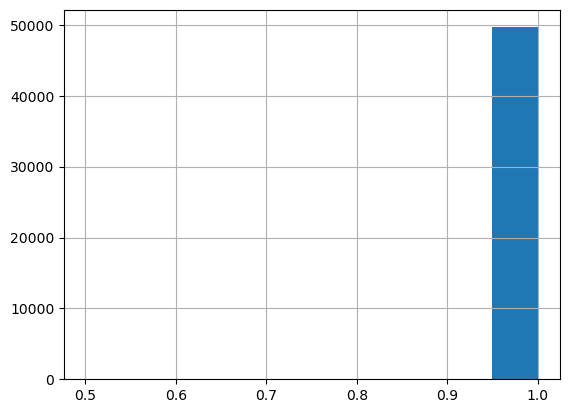

In [10]:
classifier = CellClassifier.load(CLASSIFIER_PATH)
classified_metadata, classified_features = classifier.classify_cells(metadata, features)

# Create config var for cell classes
CELL_CLASSES = list(classified_metadata["class"].unique())

# Show cell class counts and distribution
print("Cell class counts:")
print(classified_metadata["class"].value_counts())

print("\nCell class confidences:")
classified_metadata["confidence"].hist()
plt.show()

Montages of cell classes:


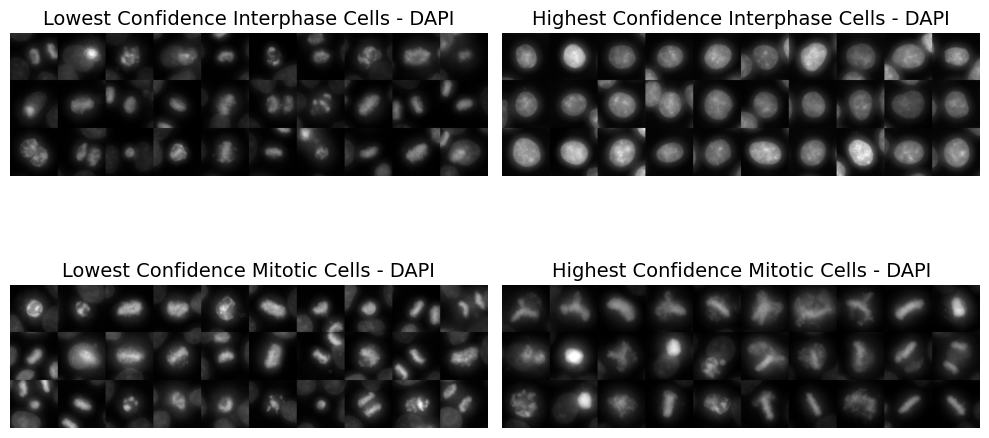

Split cell data summary:


,Stage,Count,Percent
0,Raw Data,49992,100.00
1,Interphase cells,49302,98.62
2,Interphase sgRNA_0,10784,21.57
3,Interphase gene_symbol_0,4769,9.54
4,Mitotic cells,690,1.38
5,Mitotic sgRNA_0,386,0.77
6,Mitotic gene_symbol_0,372,0.74


In [11]:
cell_classes = list(classified_metadata["class"].unique()) + ["all"]

classified_metadata_copy = classified_metadata.copy(deep=True)
classified_metadata_copy = add_filenames(classified_metadata_copy, ROOT_FP)

# Create a dictionary of DataFrames for each cell class
cell_class_dfs = {
    cell_class: classified_metadata_copy[classified_metadata_copy["class"] == cell_class]
    for cell_class in CELL_CLASSES
}

# Define sorting directions and titles
title_templates = {
    True: "Lowest Confidence {cell_class} Cells - {channel}",
    False: "Highest Confidence {cell_class} Cells - {channel}",
}

# Generate montages dynamically
montages, titles = [], []
for cell_class, cell_df in cell_class_dfs.items():
    for ascending in [True, False]:
        montage = create_cell_montage(
            cell_data=cell_df,
            channels=config["phenotype"]["channel_names"],
            selection_params={
                "method": "sorted",
                "sort_by": "confidence",
                "ascending": ascending,
            },
        )[MONTAGE_CHANNEL]
        montages.append(montage)
        titles.append(
            title_templates[ascending].format(
                cell_class=cell_class, channel=MONTAGE_CHANNEL
            )
        )

# Determine figure size dynamically
num_rows = len(CELL_CLASSES)
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

# Display montages
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

print("Montages of cell classes:")
plt.tight_layout()
plt.show()

print("Split cell data summary:")
summary_df = summarize_cell_data(classified_metadata, CELL_CLASSES, COLLAPSE_COLS)
display(summary_df)

## <font color='red'>SET PARAMETERS</font>

### Aggregate by channel combos

- `CHANNEL_COMBOS`: Combinations of channels to aggregate by. This is a list of lists with channel names, ex `[["DAPI", "CENPA"], ["DAPI", "WGA"]]`.
- `AGGREGATE_COMBO_FP`: Location of aggregate combinations dataframe.
- `TEST_CELL_CLASS`: Cell class to configure aggregate params with. Can be any of the cell classes or `all`.
- `TEST_CHANNEL_COMBO`: Channel combo to configure aggregate params with; must be one of the channel combos. Ex `["DAPI", "CENPA"]`.

In [12]:
CHANNEL_COMBOS = [["DAPI","TUBULIN","GH2AX","PHALLOIDIN"]]
AGGREGATE_COMBO_FP = "config/aggregate_combo.tsv"

TEST_CELL_CLASS = "Interphase"
TEST_CHANNEL_COMBO = ["DAPI","TUBULIN","GH2AX","PHALLOIDIN"]

In [13]:
# determine cell classes and channel combos
channel_combos = ["_".join(combo) for combo in CHANNEL_COMBOS]

# Load merge wildcard combos
MERGE_COMBO_FP = Path(config["merge"]["merge_combo_fp"])
merge_wildcard_combos = pd.read_csv(MERGE_COMBO_FP, sep="\t")

# Generate aggregate wildcard combos
aggregate_wildcard_combos = pd.DataFrame(
    product(
        merge_wildcard_combos.itertuples(index=False, name=None),
        cell_classes,
        channel_combos,
    ),
    columns=["plate_well", "cell_class", "channel_combo"],
)
aggregate_wildcard_combos[["plate", "well"]] = pd.DataFrame(aggregate_wildcard_combos["plate_well"].tolist(), index=aggregate_wildcard_combos.index)
aggregate_wildcard_combos = aggregate_wildcard_combos.drop(columns="plate_well")

# Save aggregate wildcard combos
aggregate_wildcard_combos.to_csv(AGGREGATE_COMBO_FP, sep="\t", index=False)

print("Aggregate wildcard combos:")
aggregate_wildcard_combos

Aggregate wildcard combos:


,cell_class,channel_combo,plate,well
0,Interphase,DAPI_TUBULIN_GH2AX_PHALLOIDIN,1,A3
1,Mitotic,DAPI_TUBULIN_GH2AX_PHALLOIDIN,1,A3
2,all,DAPI_TUBULIN_GH2AX_PHALLOIDIN,1,A3
3,Interphase,DAPI_TUBULIN_GH2AX_PHALLOIDIN,8,B2
4,Mitotic,DAPI_TUBULIN_GH2AX_PHALLOIDIN,8,B2
...,...,...,...,...
130,Mitotic,DAPI_TUBULIN_GH2AX_PHALLOIDIN,4,B2
131,all,DAPI_TUBULIN_GH2AX_PHALLOIDIN,4,B2
132,Interphase,DAPI_TUBULIN_GH2AX_PHALLOIDIN,1,A2
133,Mitotic,DAPI_TUBULIN_GH2AX_PHALLOIDIN,1,A2


In [14]:
# subset cell class
if TEST_CELL_CLASS != "all":
    cell_class_mask = classified_metadata["class"] == TEST_CELL_CLASS
    class_metadata = classified_metadata[cell_class_mask]
    class_features = classified_features[cell_class_mask]
else:
    class_metadata = classified_metadata
    class_features = classified_features

# subset features
all_channels = config["phenotype"]["channel_names"]
class_features = channel_combo_subset(class_features, TEST_CHANNEL_COMBO, all_channels)

# copy metadata and features for later eval
dataset_metadata = class_metadata.copy()
dataset_features = class_features.copy()

# preview metadata and features
display(class_metadata)
display(class_features)

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_bounds_2,cell_bounds_3,cytoplasm_i,cytoplasm_j,cytoplasm_bounds_0,cytoplasm_bounds_1,cytoplasm_bounds_2,cytoplasm_bounds_3,class,confidence
0,5,A1,765,476,1480.617960,1480.398021,207,221,110.716049,739.370370,...,1518,1517,1474.610710,1487.720818,1439,1443,1518,1517,Interphase,0.999876
1,5,A1,138,645,1480.787830,1480.082391,27,3139,749.488189,746.598425,...,1517,1542,1475.957035,1494.966112,1430,1444,1517,1542,Interphase,0.999954
2,5,A1,199,587,1479.814737,1481.478947,57,2807,744.725806,111.741935,...,1525,1504,1473.712731,1478.494558,1435,1452,1525,1504,Interphase,0.999914
3,5,A1,620,585,1480.131527,1481.907469,156,2435,735.074468,737.914894,...,1518,1559,1474.838738,1509.558282,1416,1446,1518,1559,Interphase,0.999964
4,5,A1,1049,624,1480.156392,1477.852675,288,351,118.401408,734.049296,...,1521,1523,1482.613843,1480.326029,1430,1431,1521,1523,Interphase,0.999874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5,A2,585,609,1323.590305,1601.719312,138,5027,1346.976471,760.976471,...,1354,1635,1319.448699,1604.657339,1286,1567,1354,1635,Interphase,0.999003
49996,5,A2,741,717,1368.303094,1316.277778,178,3182,731.614583,1324.864583,...,1399,1363,1366.092342,1320.950129,1333,1270,1399,1363,Interphase,0.999889
49997,5,A2,911,668,1577.278732,1652.684280,251,430,141.544554,777.970297,...,1618,1712,1569.315295,1663.101118,1525,1616,1618,1712,Interphase,0.999952
49998,5,A2,100,764,1586.560487,1312.882507,36,431,136.623529,704.741176,...,1626,1349,1593.479779,1313.852482,1557,1274,1626,1349,Interphase,0.999778


,nucleus_DAPI_int,nucleus_TUBULIN_int,nucleus_GH2AX_int,nucleus_PHALLOIDIN_int,nucleus_DAPI_mean,nucleus_TUBULIN_mean,nucleus_GH2AX_mean,nucleus_PHALLOIDIN_mean,nucleus_DAPI_std,nucleus_TUBULIN_std,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,4879185,4131142,806602,995594,3713.230594,3143.943683,613.852359,757.681887,604.415780,306.580790,...,5,1.000000,51.892764,53.447116,132.981918,5,0.620614,50.231461,56.375007,141.697904
1,9563976,6678080,1431158,2785067,5150.229402,3596.165859,770.682822,1499.766828,965.598295,447.536543,...,2,0.538251,67.119173,70.637434,86.247420,2,0.356884,70.473984,70.959338,83.392143
2,4606757,3234202,1720342,990580,4849.217895,3404.423158,1810.886316,1042.715789,939.860488,284.993640,...,5,1.000000,51.256842,59.843597,125.378826,5,0.645631,55.045870,56.909717,126.515435
3,6151622,5050623,1673224,1278549,4065.844019,3338.151355,1105.898215,845.042300,704.374244,174.004376,...,2,0.395506,64.573843,98.402750,144.595642,2,0.278922,66.897243,98.951225,142.148766
4,5265419,5877649,1496210,1424330,2386.862647,2664.392112,678.245694,645.661831,319.561487,119.701760,...,5,0.891599,71.568709,72.251732,144.939353,5,0.556684,69.558916,70.958721,140.297668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,7171123,4372894,1568371,958883,5606.820172,3418.994527,1226.247850,749.713057,1262.576361,296.333375,...,5,1.000000,59.631210,65.420293,115.802175,5,0.615741,61.224834,66.608594,112.643585
49996,4750574,4575095,1413195,1399178,3340.769339,3217.366385,993.808017,983.950774,521.195579,269.147075,...,4,0.797468,57.294078,62.372804,171.178748,4,0.506024,58.688615,63.036778,166.754164
49997,5103860,4346605,1277943,1007258,3371.109643,2870.941215,844.083884,665.295905,571.208565,134.280198,...,7,0.835544,63.316978,64.256427,175.272227,7,0.568592,58.901384,69.645655,172.320277
49998,4430336,3814609,871444,702206,3855.818973,3319.938207,758.436902,611.145344,652.162119,181.598000,...,6,0.858657,49.421865,57.513778,127.947646,6,0.551020,50.809566,51.776000,136.927676


## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `FILTER_QUERIES`: Queries to use for custom filtering; ex: `["mapped_single_gene == False", "cell_quality_score > 0.8"]`. Can be left as `None` for no filtering.
- `PERTURBATION_NAME_COL`: Name of column used to identify perturbations. This is the column that aggregation takes place on. Ex "gene_symbol_0".

In [15]:
FILTER_QUERIES = ["mapped_single_gene == 'True'"]
PERTURBATION_NAME_COL = "gene_symbol_0"

Query 'mapped_single_gene == 'True'' filtered out 16847 cells
Found 32455 cells with assigned perturbations
Unique populations: 4773


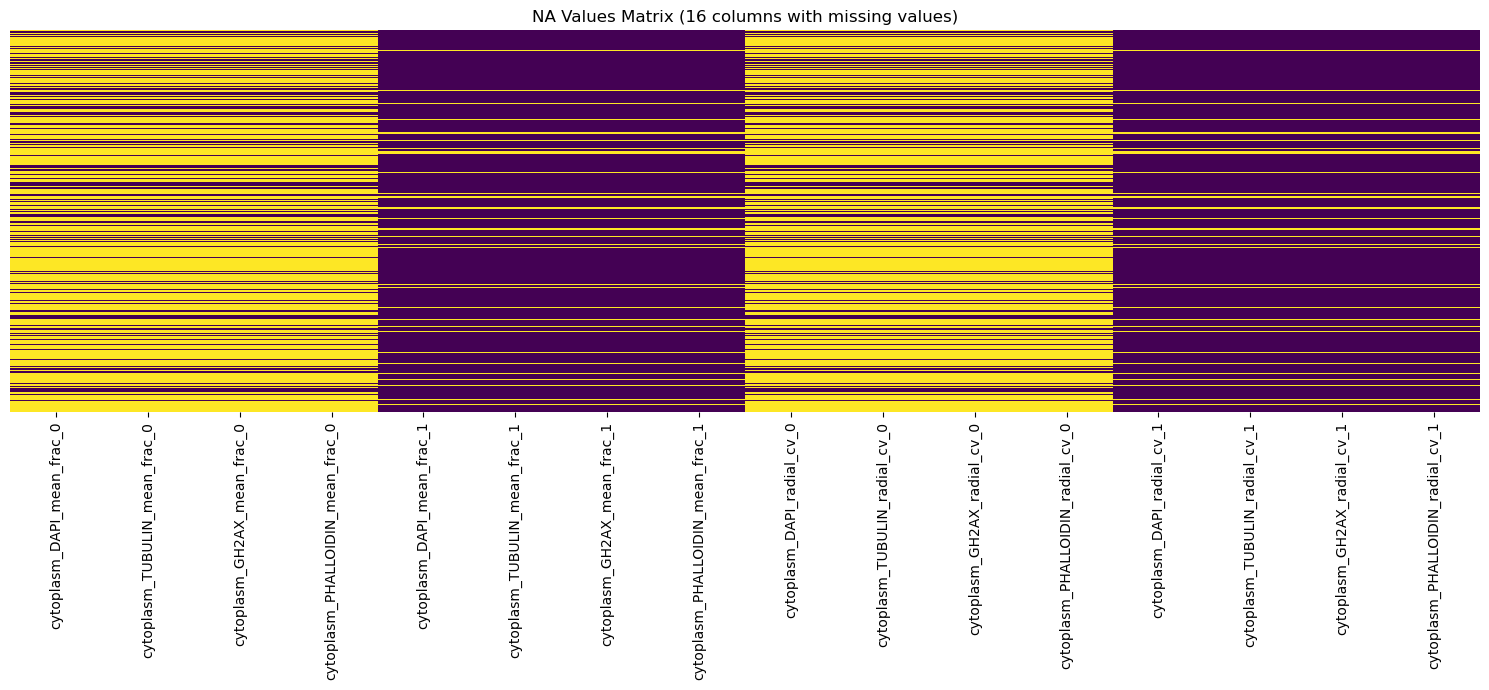

In [16]:
qf_metadata, qf_features = query_filter(class_metadata, class_features, FILTER_QUERIES)

pf_metadata, pf_features = perturbation_filter(
    qf_metadata, qf_features, PERTURBATION_NAME_COL
)
print(f"Unique populations: {metadata[PERTURBATION_NAME_COL].nunique()}")

sumamry_df, fig = nas_summary(pf_features)
sumamry_df[sumamry_df["percent_na"] > 0.1]
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`
- `DROP_ROWS_THRESHOLD`: Threshold of NA values above which an entire row is dropped. Usually `0.01`
- `IMPUTE`: Whether or not to impute remaining missing values. Usually `True`

**Note**: All NAs must be dropped or imputed to perform feature alignment.

In [17]:
DROP_COLS_THRESHOLD = 0.05
DROP_ROWS_THRESHOLD = 0.01
IMPUTE = True

In [18]:
# Filter by missing values
mvf_metadata, mvf_features = missing_values_filter(
    pf_metadata,
    pf_features,
    drop_cols_threshold=DROP_COLS_THRESHOLD,
    drop_rows_threshold=DROP_ROWS_THRESHOLD,
    impute=True,
)

mvf_metadata.shape, mvf_features.shape

Dropping 16 columns with ≥5.0% missing values
Dropped 0 rows with ≥1.0% missing values


((32455, 37), (32455, 1633))

## <font color='red'>SET PARAMETERS</font>

### Intensity filtering

- `CONTAMINATION`: Expected proportion of outliers in dataset. Usually `0.01`

In [19]:
CONTAMINATION = 0.01

In [20]:
# Filter by intensity outliers
if_metadata, if_features = intensity_filter(
    mvf_metadata,
    mvf_features,
    config["phenotype"]["channel_names"],
    CONTAMINATION,
)

if_metadata.shape, if_features.shape

((32130, 37), (32130, 1633))

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`.
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.
- `PERTURBATION_ID_COL`: Name of column that identifies unique perturbations. Only needed if you want your controls to have different perturbation names, ex `sgRNA_0`. Otherwise, can leave this as `None`.

In [21]:
BATCH_COLS = ["plate", "well"]
CONTROL_KEY = "nontargeting"
PERTURBATION_ID_COL = "sgRNA_0"

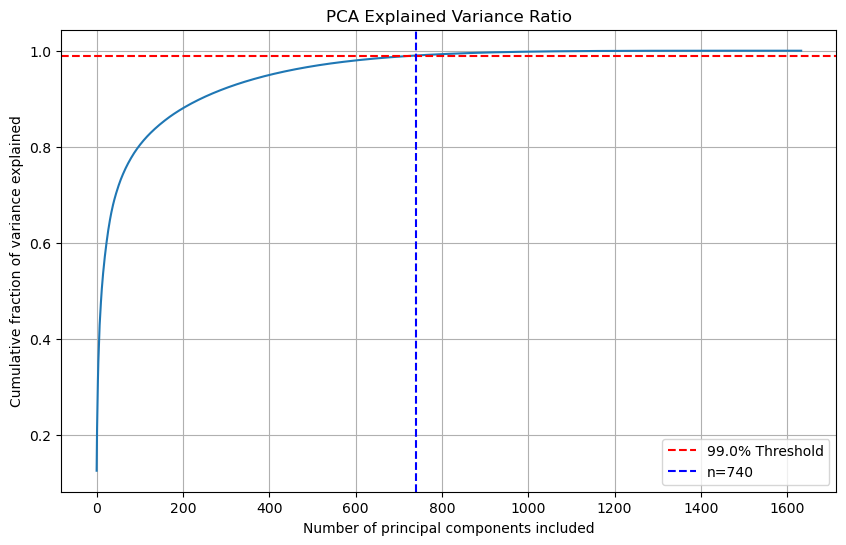

In [22]:
pad_metadata, pad_features = prepare_alignment_data(
    if_metadata, if_features, BATCH_COLS, PERTURBATION_NAME_COL, CONTROL_KEY, PERTURBATION_ID_COL
)

n_components, fig = pca_variance_plot(
    pad_features, variance_threshold=0.99
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `VARIANCE_OR_NCOMP`: Variance or number of components to keep after PCA.
- `NUM_ALIGN_BATCHES`: Number of batches to use when aligning, usually `1`. Increase this if you are running out of memory while aligning. We were able to barely fit 8 plates with 6 wells each in 1 TB of memory with `NUM_ALIGN_BATCHES=1`.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `median`.

While we use a simplified aggregate method in the notebook, the way this works during a normal run is:
1) Take a subset of 1,000,000 cells, or the entire dataset, whichever is smaller and compute a PCA transform with `VARIANCE_OR_NCOMP`.
2) Subset the entire dataset `NUM_BATCHES` number of times and align cells in this batch.
3) Aggregate across all aligned cell data.

In [23]:
VARIANCE_OR_NCOMP = 0.99
NUM_ALIGN_BATCHES = 1
AGG_METHOD = "median"

In [24]:
pca_embeddings = embed_by_pca(
    pad_features, pad_metadata, variance_or_ncomp=VARIANCE_OR_NCOMP, batch_col="batch_values"
)

tvn_normalized = tvn_on_controls(
    pca_embeddings, pad_metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values"
)

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, pad_metadata, PERTURBATION_NAME_COL, AGG_METHOD
)

feature_columns = [f"PC_{i}" for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(
    tvn_normalized, index=pad_metadata.index, columns=feature_columns
)
aligned_cell_data = pd.concat([pad_metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(
    aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns
)
aggregated_cell_data = (
    pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1)
    .sort_values("cell_count", ascending=False)
    .reset_index(drop=True)
)

/lab/cheeseman_ops/brieflow-screens/aconcagua-analysis/brieflow/workflow/lib/aggregate/align.py:242: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/cheeseman_ops/brieflow-screens/aconcagua-analysis/brieflow/workflow/lib/aggregate/align.py:242: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/cheeseman_ops/brieflow-screens/aconcagua-analysis/brieflow/workflow/lib/aggregate/align.py:174: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less seq

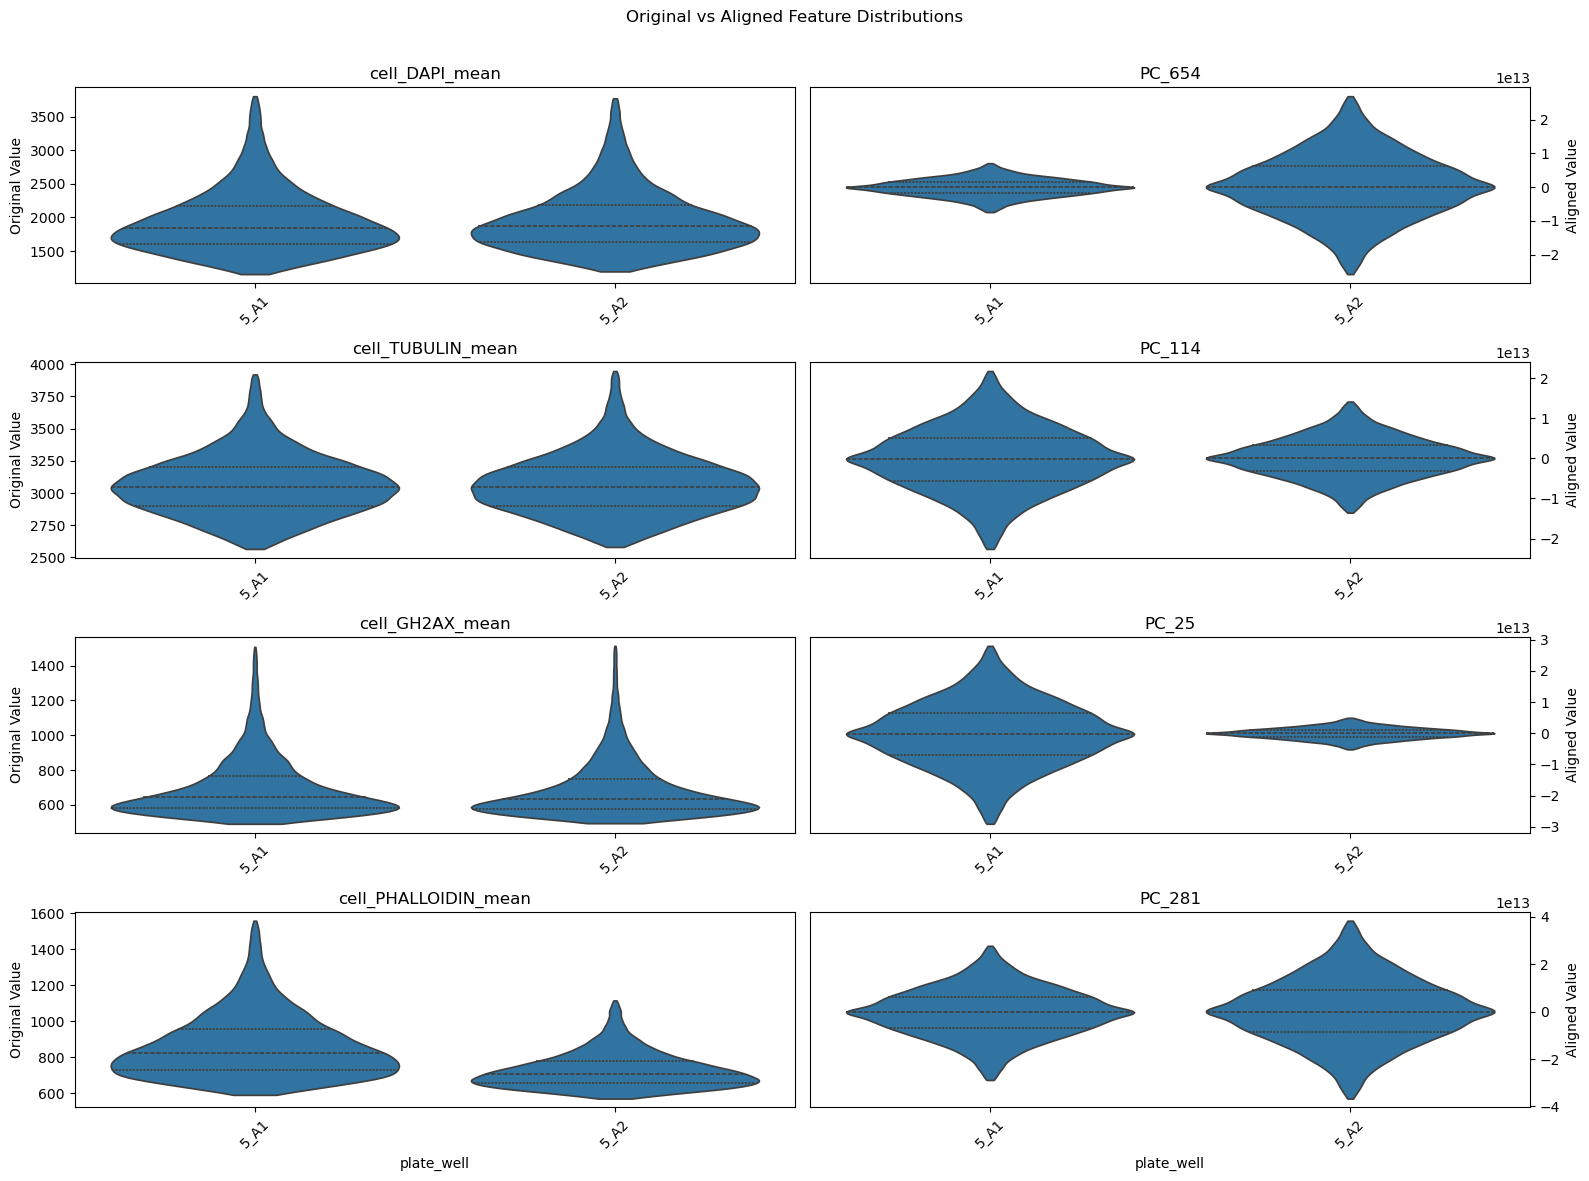

In [25]:
original_feature_cols = [col for col in dataset_features.columns if ("cell_" in col and col.endswith("_mean"))]
pc_cols = [col for col in aggregated_cell_data.columns if col.startswith("PC_")]
aligned_feature_cols = random.sample(pc_cols, k=min(len(original_feature_cols), len(pc_cols)))

original_cell_data = pd.concat([dataset_metadata, dataset_features], axis=1)
original_cell_data

feature_distributions_fig = plot_feature_distributions(
    original_feature_cols,
    original_cell_data,
    aligned_feature_cols,
    aligned_cell_data,
)
plt.show()

## Add aggregate parameters to config file

In [26]:
# Add aggregate section
config["aggregate"] = {
    "metadata_cols_fp": METADATA_COLS_FP,
    "collapse_cols": COLLAPSE_COLS,
    "classifier_path": CLASSIFIER_PATH,
    "aggregate_combo_fp": AGGREGATE_COMBO_FP,
    "filter_queries": FILTER_QUERIES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "drop_rows_threshold": DROP_ROWS_THRESHOLD,
    "impute": IMPUTE,
    "contamination": CONTAMINATION,
    "batch_cols": BATCH_COLS,
    "control_key": CONTROL_KEY,
    "perturbation_id_col": PERTURBATION_ID_COL,
    "variance_or_ncomp": VARIANCE_OR_NCOMP,
    "num_align_batches": NUM_ALIGN_BATCHES,
    "agg_method": AGG_METHOD,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)